# 2.0.2: Fill AoA (for 1km maps only)

Due to compute and memory limitations, calculation of the Dissimilarity Index (DI), and thus the Area of Applicability (AoA), was limited to a random sample of only 50% of the predict features. This is sufficient for calculating these statistics, but less ideal when it comes to providing the AoA as a mask for the final predictions.

To address this, we can simply interpolate the missing 50% of grid cells using nearest neighbor interpolation.

## Imports and config

In [8]:
import numpy as np
import rasterio as rio
from scipy.interpolate import NearestNDInterpolator

from src.conf.conf import get_config
from src.conf.environment import log

cfg = get_config()

Load both the AoA and the predictions (as reference for where we expect valid AoA values).

In [23]:
from src.utils.dataset_utils import get_aoa_dir, get_predict_dir

trait_set = "splot_gbif"
trait = list(get_predict_dir().glob("*"))[0].stem

predict_path = (
    get_predict_dir() / trait / trait_set / f"{trait}_{trait_set}_predict.tif"
)
aoa_path = get_aoa_dir() / trait / trait_set / f"{trait}_{trait_set}_aoa.tif"
predict = rio.open(predict_path).read(1)
aoa = rio.open(aoa_path).read(2)

Define a function to interpolate the missing values using nearest neighbors with the assistance of K-d trees.

In [48]:
from scipy.spatial import cKDTree

def interpolate_aoa_kdtree(aoa: np.ndarray, predict: np.ndarray) -> np.ndarray:
    # ensure all values that are not equal to 1 or 0 are set to nan
    aoa = np.where((aoa == 1) | (aoa == 0), aoa, np.nan)
    nan_mask = np.isnan(aoa)
    reference_valid_mask = ~np.isnan(predict)
    interpolation_mask = nan_mask & reference_valid_mask

    x_coords, y_coords = np.meshgrid(np.arange(aoa.shape[1]), np.arange(aoa.shape[0]))

    valid_x = x_coords[~nan_mask].ravel()
    valid_y = y_coords[~nan_mask].ravel()
    valid_values = aoa[~nan_mask].ravel()

    tree = cKDTree(np.c_[valid_x, valid_y])

    interp_x = x_coords[interpolation_mask].ravel()
    interp_y = y_coords[interpolation_mask].ravel()

    _, indices = tree.query(np.c_[interp_x, interp_y], k=1)

    interpolated_values = valid_values[indices]

    filled_raster = aoa.copy()
    filled_raster[interpolation_mask] = interpolated_values 

    return filled_raster

aoa_interp = interpolate_aoa_kdtree(aoa, predict)

Confirm that we retained only values of 0 and 1 (where 0 indicates a pixel is *within* the AoA).

In [51]:
np.unique(aoa_interp)

array([ 0.,  1., nan], dtype=float32)

Lastly, confirm that the number of `nan`s present in the interpolated AoA grid match the number of `nan`s in the prediction grid.

In [53]:
np.isnan(predict).sum() == np.isnan(aoa_interp).sum()

True

Plot a coarsened version of the new AoA mask for quick sanity check.

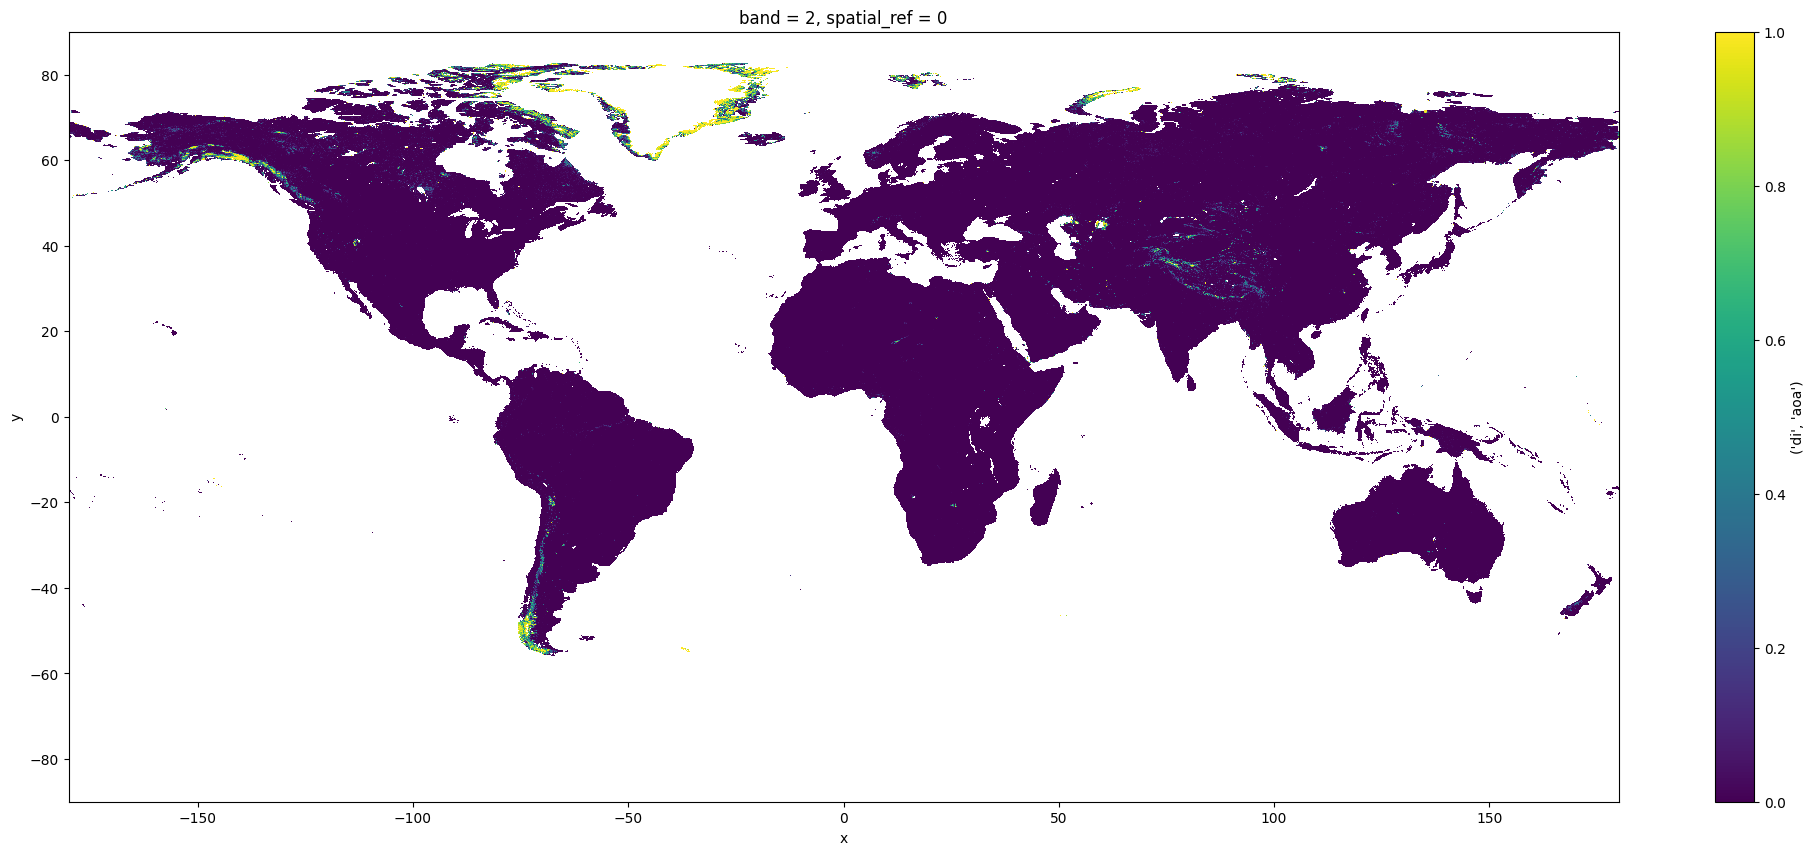

In [57]:
from src.utils.raster_utils import open_raster

# Load the original aoa raster using rioxarray to take advantage of its built-in
# coordinate handling and plotting functionality
aoa_xr = open_raster(aoa_path).sel(band=2)

# Replace the values with the new interpolated values
aoa_xr.data = aoa_interp

# Plot the interpolated raster (upsampled for speed)
aoa_xr.coarsen(x=10, y=10).mean().plot(figsize=(25,10))

(Optional) Save the results to disk to inspect the data more closely.

In [52]:
profile = rio.open(predict_path).profile

with rio.open("test.tif", "w", **profile) as dst:
    dst.write(aoa_interp, 1)